<a href="https://colab.research.google.com/github/kk7188048/ML-From-Scratch/blob/master/MegaTron_The_call_of_Transformers(Attention_is_all_you_need_Research_Paper).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q torchdata torchtext spacy altair GPUtil
!python -m spacy download de_core_news_sm
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 140.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 145.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import torch
import torch.nn as nn
from torch.nn.functional import log_softmax, pad
import torch.nn.functional as F
import math

Implementing input embeddings

In [ ]:
class PositionalEncoding(nn.Module):
  def __init__(self, d_model:int, dropout:float, max_len:int):
    # We apply dropout to the sum of the embeddings and the positional encodings in both the encoder and decoder
    super().__init__()
    # div_term[i]=10000^2i/d_model
    # 10000^a=e^(a⋅ln(10000))
    self.d_model = d_model
    self.dropout = nn.Dropout(dropout)
    self.max_len = max_len
    pe = torch.zeros(max_len, d_model)
    position = torch.arange(0, max_len).unsqueeze(1).float()
    div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
# This is because the sine and cosine terms use the same frequency for each paired dimension, but the mathematical function (sin/cos) alternates.
#     At each position, for each pair of dimensions:
# 2i (even) uses sin
# 2i+1 (odd) uses cos
# Both use the same underlying frequency (from div_term[i])
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    pe = pe.unsqueeze(0)
    self.register_buffer('pe', pe)
  def forward(self, x):
    x = x + self.pe[:,:x.size(1),:]
    return self.dropout(x)

![image.png](
  
)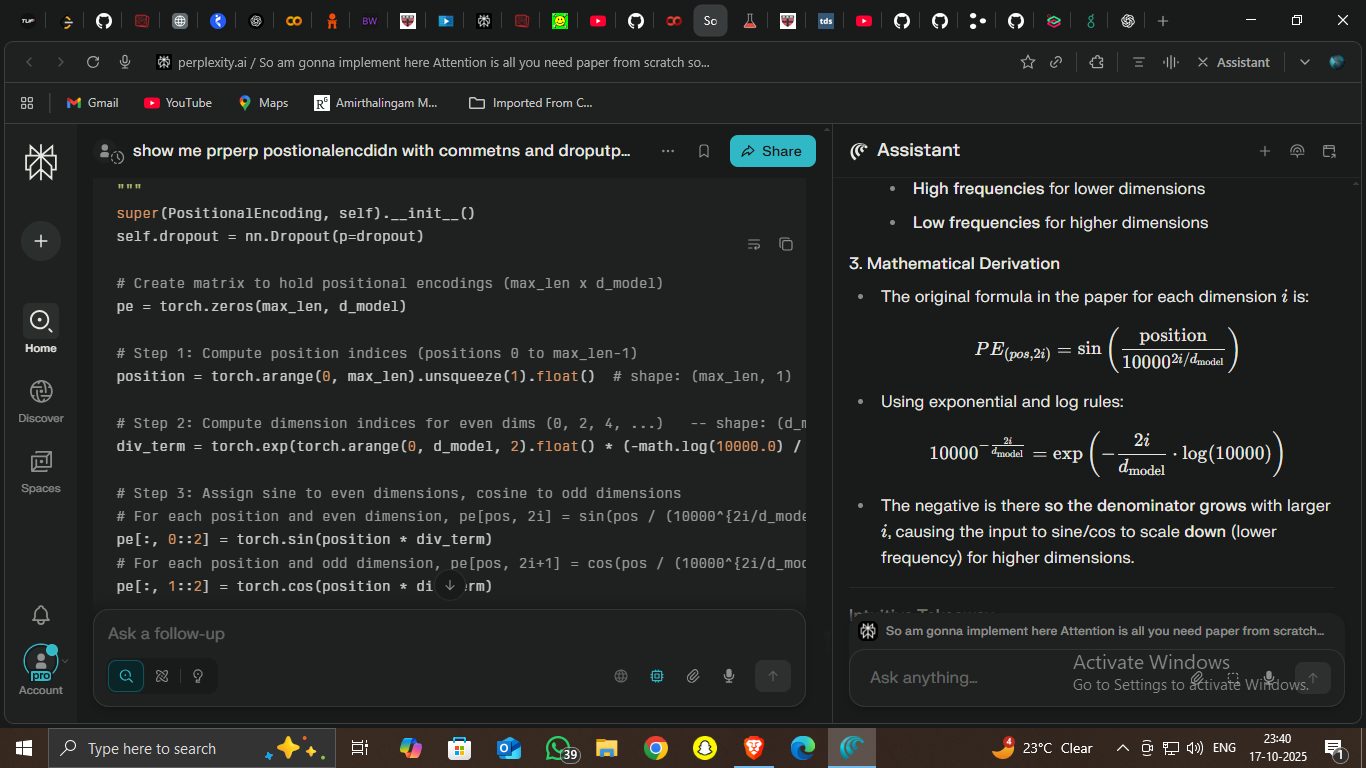

In [ ]:

torch.arange(0, 4)

tensor([0, 1, 2, 3])

In [ ]:
torch.arange(0, 4).unsqueeze(1)

tensor([[0],
        [1],
        [2],
        [3]])

In [ ]:
class MultiheadAttention(nn.Module):
    def __init__(self, d_model, num_heads, dropout):
      super().__init__()
      self.d_model = d_model
      self.num_heads = num_heads
      self.dropout = nn.Dropout(dropout)
      # Make sure d_model is divisible by h
      assert d_model % num_heads == 0, "d_model is not divisible by h"
      self.d_k = d_model // num_heads # Dimension of vector seen by each head
      self.w_q = nn.Linear(d_model, d_model, bias = False)
      self.w_k = nn.Linear(d_model, d_model, bias = False)
      self.w_v = nn.Linear(d_model, d_model, bias = False)
      self.w_o = nn.Linear(d_model, d_model, bias=False)

    def scaled_dot_product_attention(q,k,v,dropout:nn.Dropout, mask=None):
      scores = torch.mm(q,k.transpose(-2,-1))/q.size(-1)**0.5
      # (query @ key.transpose(-2, -1)) / math.sqrt(d_k)
      # Q.size(−1) and K . s i z e ( − 1 ) K.size(−1) are always equal, both equal to d k d k .
      # The original Transformer code and most tutorials use Q.size(-1) just for consistency (since all three matrices, Q, K, V, are created by multiplying the input by different learned weights but with the same head dimension).
      if mask is not None:
        scores = scores.masked_fill(mask == 0, float('-inf'))
      if dropout is not None:
        scores = dropout(scores)
      attn_weights = F.softmax(scores, dim = -1)
      output = torch.matmul(attn_weights, v)
      return attn_weights, output

    def forward(self,q,k,v, mask=None):
      batch_size = q.size(0)
      q = self.w_q(q).view(batch_size, -1, self.num_heads, self.d_k).transpose(1,2)
      k = self.w_k(k).view(batch_size, -1, self.num_heads, self.d_k).transpose(1,2)
      v = self.w_v(v).view(batch_size, -1, self.num_heads, self.d_k).transpose(1,2)
      attn_weights, attn_output = scaled_dot_product_attention(q,k,v,self.dropout, mask)
      attn_output = attn_output.transpose(1,2).contiguous().view(batch_size, -1, self.num_heads * self.d_k)
      output = self.w_o(attn_output)
      return output, attn_weights

In [ ]:
class LayerNormalization(nn.Module):
  def __init__(self, d_model, eps=1e-5):
    super().__init__()
    self.eps = eps
    self.gamma = nn.Parameter(torch.ones(d_model))
    self.beta = nn.Parameter(torch.zeros(d_model))

  def forward(self,x):
    mean = x.mean(dim=-1,keepdim=True)
    var = x.var(dim=-1, keepdim=True, unbiased=False)
    x_hat = (x - mean) / torch.sqrt(var + self.eps)
    return self.gamma * x_hat + self.beta

In [ ]:
import torch.nn as nn

class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        x = self.linear1(x)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        return x

In [ ]:
class InputEmbeddings(nn.Module):
  def __init__(self, d_model, vocab_size):
    super().__init__()
    self.d_model = d_model
    self.vocab_size = vocab_size
    self.embedding = nn.Embedding(vocab_size, d_model)

  def forward(self, x):
    return self.embedding(x) * (self.d_model ** 0.5)

In [ ]:
class ProjectionLayer(nn.Module):
  def __init__(self, d_model, vocab_size):
    super().__init__()
    self.proj = nn.Linear(d_model, vocab_size)

  def forward(self, x):
    return self.proj(x)

In [ ]:
class EncoderLayer(nn.Module):
  def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
    super().__init__()
    self.self_attention = MultiheadAttention(d_model, num_heads, dropout)
    self.norm1 = LayerNormalization(d_model)
    self.feed_forward = PositionwiseFeedForward(d_model, d_ff, dropout)
    self.norm2 = LayerNormalization(d_model)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x, mask = None):
    attn_out, _ = self.self_attention(x, x, x, mask)
    x = self.norm1(x + self.dropout(attn_out))

    ffn_out = self.feed_forward(x)
    x = self.norm2(x + self.dropout(ffn_out))

    return x

class EncoderStack(nn.Module):
  def __init__(self, vocab_size, d_model, num_heads, d_ff, num_layers, max_len, dropout=0.1):
    super().__init__()
    self.embedding = InputEmbeddings(d_model, vocab_size)
    self.positional_encoding = PositionalEncoding(d_model, dropout, max_len)
    self.layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
    self.norm = LayerNormalization(d_model)

  def forward(self, x, mask=None):
    x = self.embedding(x)
    x = self.positional_encoding(x)
    for layer in self.layers:
      x = layer(x, mask)
    x = self.norm(x)             # Final LayerNorm (optional per paper, often used)
    return x

In [ ]:
import torch
import torch.nn as nn

class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.self_attn = MultiheadAttention(d_model, num_heads, dropout)
        self.norm1 = LayerNormalization(d_model)
        self.enc_dec_attn = MultiheadAttention(d_model, num_heads, dropout)
        self.norm2 = LayerNormalization(d_model)
        self.ffn = PositionwiseFeedForward(d_model, d_ff, dropout)
        self.norm3 = LayerNormalization(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_out, tgt_mask=None, src_mask=None):
        # Masked Self-Attention
        self_attn_out, _ = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(self_attn_out))
        # Encoder-Decoder Attention
        enc_dec_attn_out, _ = self.enc_dec_attn(x, enc_out, enc_out, src_mask)
        x = self.norm2(x + self.dropout(enc_dec_attn_out))
        # Feed Forward
        ffn_out = self.ffn(x)
        x = self.norm3(x + self.dropout(ffn_out))
        return x
class DecoderStack(nn.Module):
    def __init__(self, vocab_size, d_model, num_heads, d_ff, num_layers, max_len, dropout=0.1):
        super().__init__()
        self.embedding = InputEmbeddings(d_model, vocab_size)
        self.pos_encoding = PositionalEncoding(d_model, dropout, max_len)
        self.layers = nn.ModuleList([
            DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)
        ])
        self.norm = LayerNormalization(d_model)

    def forward(self, tgt, enc_out, tgt_mask=None, src_mask=None):
        x = self.embedding(tgt)
        x = self.pos_encoding(x)
        for layer in self.layers:
            x = layer(x, enc_out, tgt_mask, src_mask)
        x = self.norm(x)
        return x

In [ ]:
import torch
import torch.nn as nn

class Transformer(nn.Module):
    def __init__(
        self,
        src_vocab_size,
        tgt_vocab_size,
        d_model,
        num_heads,
        d_ff,
        num_layers,
        max_len,
        dropout=0.1,
    ):
        super().__init__()
        self.encoder = EncoderStack(src_vocab_size, d_model, num_heads, d_ff, num_layers, max_len, dropout)
        self.decoder = DecoderStack(tgt_vocab_size, d_model, num_heads, d_ff, num_layers, max_len, dropout)
        self.out_proj = nn.Linear(d_model, tgt_vocab_size)  # vocabulary projection

    def forward(self, src, tgt, src_mask=None, tgt_mask=None):
        # src: (batch, src_seq_len), tgt: (batch, tgt_seq_len)
        enc_out = self.encoder(src, src_mask)  # (batch, src_seq_len, d_model)
        dec_out = self.decoder(tgt, enc_out, tgt_mask, src_mask)  # (batch, tgt_seq_len, d_model)
        logits = self.out_proj(dec_out)  # (batch, tgt_seq_len, tgt_vocab_size)
        return logits
